In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
#pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_67955/2318198399.py:29: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [4]:
runners = pd.read_csv('data/cherryBlossomMen.csv')
dogs = pd.read_csv('data/akc.csv').dropna()

sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)

/var/folders/s2/cw87rxkn0bx03lwlr3n06skh0001l0/T/ipykernel_67955/1187267164.py:4: FutureWarning:

The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.



b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


## Smoothing and Aggregating Data

When we have lots of data, we often don't want to plot all of the individual data points. The scatter plot below shows data from the Cherry Blossom Run, an annual 10-mile race that takes place in April in Washington D.C. when the cherry trees are in bloom. These data were scraped from the Run's Web pages and include official times and other information for all registered male runners from 1999 to 2012. We've put the runner's age on the x-axis and race time on the y-axis.

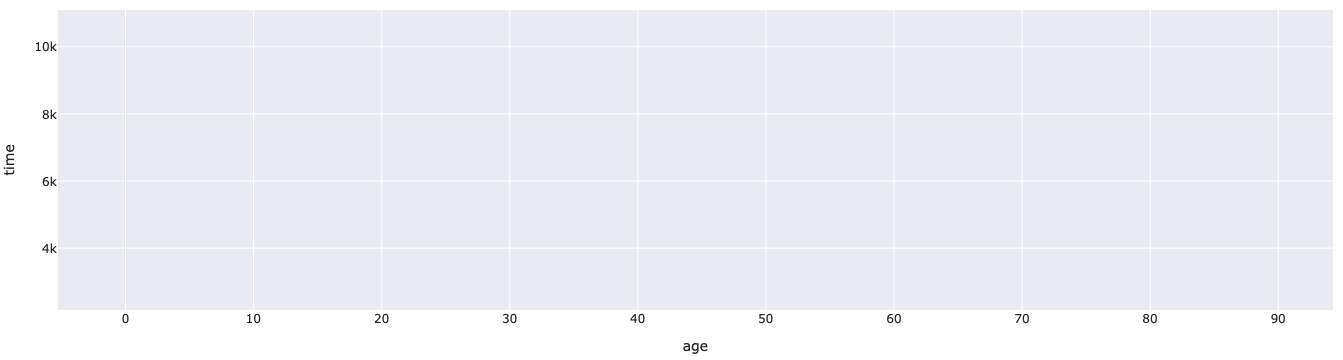

In [5]:
fig = go.Figure(
    data=go.Scattergl(x=runners['age'], y=runners['time'], mode='markers'),
    layout=dict(width=350, height=250)
)

fig.update_xaxes(title_text='age')
fig.update_yaxes(title_text='time')
fig

This scatter plot contains over 70,000 points. With so many points, many of them overlap with each other. This is a common problem called over-plotting. In this case, over-plotting prevents us from seeing how time and age are related. About the only thing that we can see in this plot is a group of very young runners, which points to issues in the data. To address over-plotting, we use smoothing techniques that aggregate data before plotting.

## Smoothing Techniques to Uncover Shape

The histogram is a familiar type of plot that uses smoothing. A histogram aggregates data values by putting points into bins and plotting one bar for each bin. Smoothing here means that we can not differenitate the location of individual points in a bin; that is, they are being displayed smoothly across the bin. For this reason, the area of a bin corresponds to the percentage (or count or proportion) of points in the bin. (Often the bins are equal in width and we take a shortcut to label the height of a bin as the proportion.)

The histogram below plots the distribution of lifespans for dog breeds. Above the histogram is a rug plot that draws a single line for every data value. We can see in the tallest bin that even a small amount of data can cause overplotting in the rug plot. By smoothing out the points in the rug plot, the histogram reveals the general shape of the distribution. In this case, we see that many breeds have a longevity of about 12 years. For more on how to read and interpret histograms, see {numref}'Section %s sec:eda_distributions'.

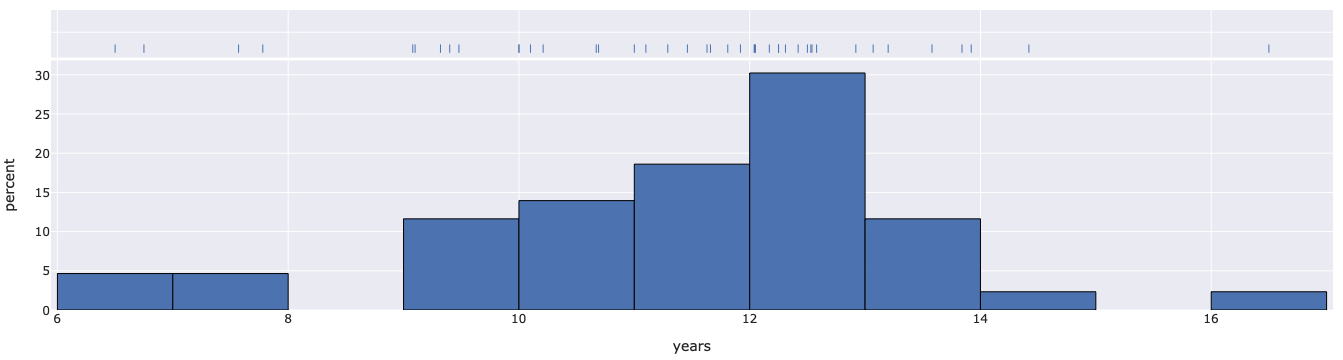

In [6]:
fig = px.histogram(dogs, x="longevity", marginal="rug", nbins=20,
                   labels={"longevity":"years"},
             histnorm='percent', width=350, height=250)
fig.data[0].marker.line =  dict( color = 'black',width = 1)
fig

Another common smoothing technique is kernel density estimation (KDE). A KDE plot shows the distribution using a smooth curve rather than bars. In the plot below, we show the same histogram of dog longevities with a KDE curve overlain on top. We can see the KDE curve shows a similar shape distribution as the histogram.

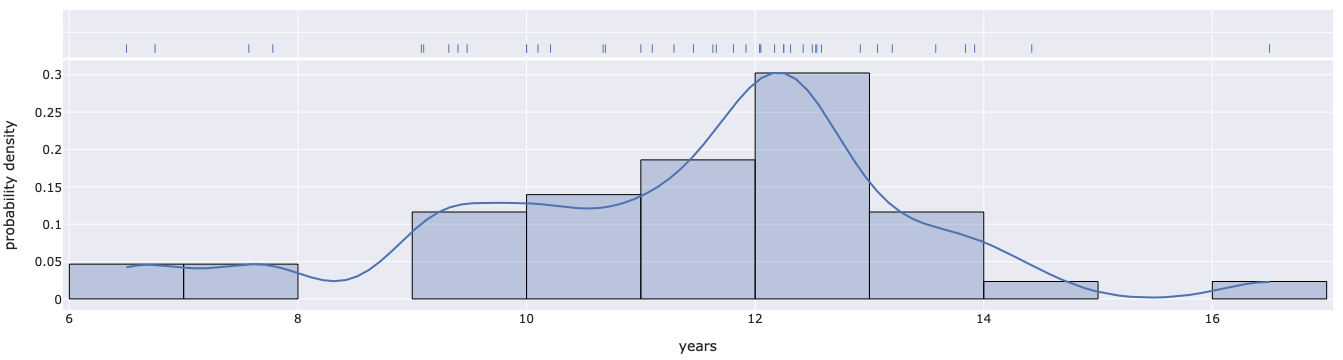

In [7]:
from scipy.stats import gaussian_kde

fig = px.histogram(dogs, x="longevity", marginal="rug",
                   histnorm='probability density', nbins=20,
                   labels={"longevity":"years"},
                   width=450, height=250)

fig.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

fig.data[0].marker.line =  dict( color = 'black',width = 1)

bandwidth = 0.2
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'], bandwidth)(xs)
curve = go.Scatter(x=xs, y=ys)

fig.add_trace(curve)
fig.update_traces(marker_color='rgb(76,114,176)',
                  selector=dict(type='scatter'))
fig.update_layout(showlegend=False)


It might have come as a surprise to think of a histogram as a smoothing method. The more computationally intensive smoother, the kernel density estimator, is useful for continuous numeric data. Both the KDE and histogram aim to help you see important features in the distibution of values. What about plots for two variables, like scatter plots? There are similar techniques to histograms and kernel density estimates for smoothing pairs of features when we have lots of data. This is the topic of the next section.

## Smoothing Techniques to Uncover Relationships and Trends

We can find high density regions of a scatter plot by binning data, like in a histogram. The plot below, remakes the earlier scatter plot of the Cherry Blossom race times against age. (Note that we have dropped the dubious young runners from this plot). This plot uses rectangular bins to aggregate points together, and then shades the rectangles based on how many points fall in them.

In [8]:
runnersOver17 = runners[runners["age"] > 17]

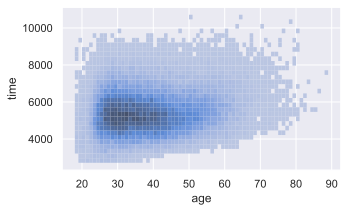

In [9]:
plt.figure(figsize=(5, 3))
sns.histplot(runnersOver17, x='age', y='time', binwidth=[1, 250]);

Notice the high density region in the 25 to 40 age group signified by the dark blue region in the plot. The plot shows us that many of the runners in this age range complete the race in around 5000 seconds (about 80 minutes). We can also see upward curvature in the medium blue region for the 40-60 age group, indicating these runners are slower than the 25 to 40 age group, but there are quite a few of them.

Kernel density estimation also works in two dimensions. When we use KDE in two dimensions, we plot the contours of the resulting two-dimensional curve. You read this plot like a topographical map.

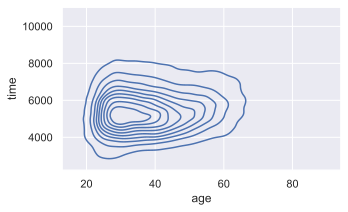

In [10]:
# Takes a while to run!
plt.figure(figsize=(5, 3))
sns.kdeplot(data=runnersOver17, x='age', y='time');

The two-dimensional KDE gives similar insights as the shaded bins. In this example, we see a high concentration of runners in the 25 to 40 age group and these runners have times that appear to be roughly 5000 seconds.
Using smoothing techniques lets us get a better picture of lots of data. Smoothing can reveal the location of high concentration of data values and the shape of these high concentration areas, which can be impossible to otherwise see.

Another smoothing approach that can be even more informative, smooths the y-values for points with a similar x-value. To explain, let's group together runners with similar ages; we use five-year increments: 20-25, 25-30, 30-35, etc. Then, for each 5-year bin of runners, we average their race times, plot the average time for each group, and connect the points to form a "curve". Such a curve appears below.

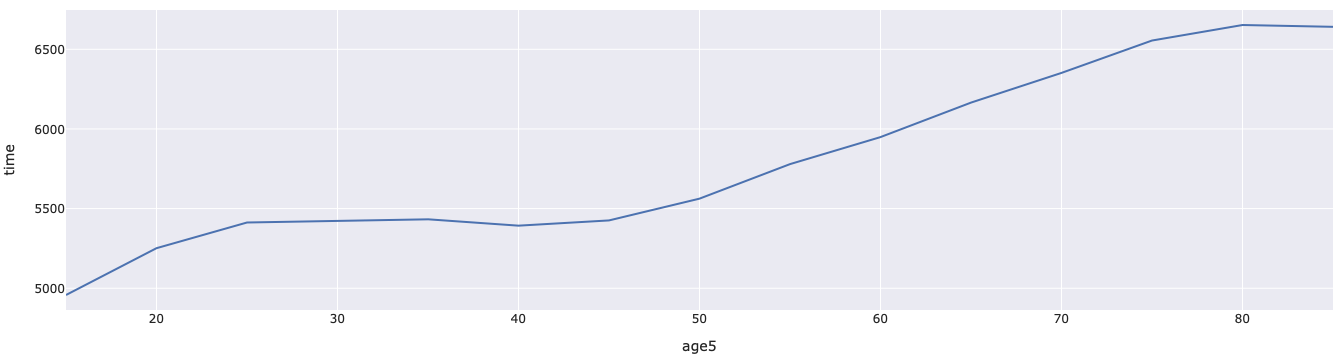

In [13]:
times = (
    runnersOver17.assign(age5=runnersOver17['age']//5*5)
    .groupby('age5')
    ['time']
    .mean()
    .reset_index()
)

px.line(times, x='age5', y='time', width=350, height=250)

This plot shows once again that runners in the 25 to 40 year age range have typical run times of about 5400 seconds. It also show that older runners took longer to complete the race on average (not really a surprise, but it wasn't nearly as evident in the earlier plots). The dip in tmes for runners under 20 and the flattening of the curve at 80 may be simply the result of fewer and fitter runners in these groups. There are other smoothing techniques to view trends. Some use a kernel smoothing approach, similar to the KDE. We don't go into the details here.

Whether using a binning or kernel smoothing technique, these methods rely on a tuning parameter that specifies the width of the bin or the spread of the kernel, and we often need to specify tis parameter when making a histogram, KDE, or smooth curve. This is the topic of the next section.

## Smoothing Techniques Need Tuning

Now that we've seen how smoothing is useful for plotting, we turn to the issue of tuning. For histograms, the width of the bins or, equivalently, for equal-width bins, the number of bins affect the look of the histogram. For example, the left histogram of longevity below has a few wide bins, and the right histogram has many narrow bins. In both cases, it's hard to see the shape of the distribution. With a few wide bins, we have over-smoothed the distribution, which makes it impossible to discern modes and tails. On the other hand, too many narrow bins, gives a plot that's little better than a rug plot. KDE plots have a parameter called the "bandwidth" that works similarly to the binwidth of a histogram.

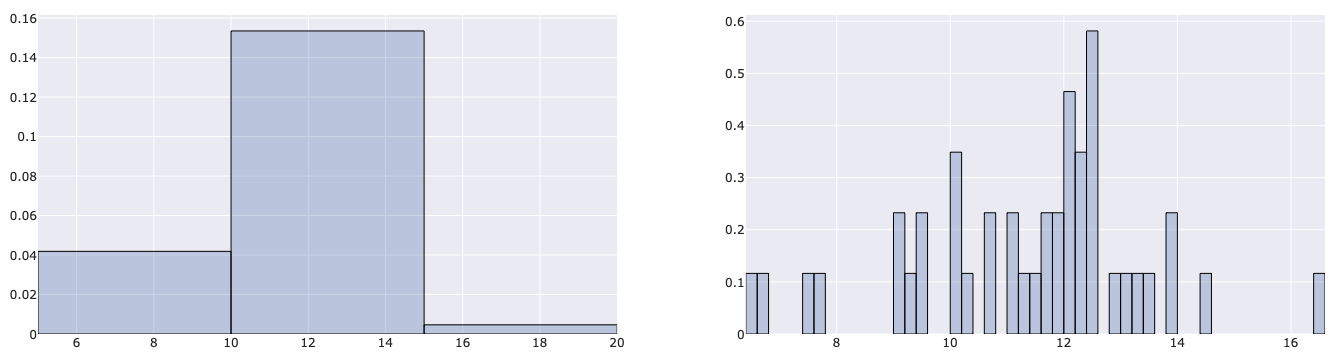

In [14]:
f1 = px.histogram(dogs, x="longevity", nbins=3, histnorm='probability density',
             width=350, height=250)

f1.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f1.data[0].marker.line =  dict( color = 'black',width = 1)

#bandwidth = 0.5
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'])(xs)
curve = go.Scatter(x=xs, y=ys)
f1.add_trace(curve)

f2 = px.histogram(dogs, x="longevity", nbins=100, histnorm='probability density',
             width=350, height=250)
f2.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f2.data[0].marker.line =  dict( color = 'black',width = 1)


left_right(f1, f2, height=250)

Most histogram and KDE software automatically chooses the binwidth for the histogram and bandwidth for the kernel. However, these parameters often need a bit of fiddling to create the most useful plot. When you create visualizations that rely on tuning paramters, it's important to try a few different values before settling on one.

A different approach to data reduction is to examine the quantiles. This is the topic of the next section.

## Reducing Distributions to Quantiles

We found in {numref}'Chapter %sch:eda' that while box plots aren't as informative as histograms, they can be useful when comparing the distributions of many groups at once. A box plot reduces the data to a few essential features based on the data quartiles. More generally, quantiles (the lower quartile, median, and upper quartile are the 25th, 50th, and 75th quantiles) can provide a useful reduction in the data when comparing distributions.

When two distributions are roughly similar, it can be hard to see the differences using histograms. For instance, the histograms below show the price distributions for two- and four-bedroom houses in the SF housing data. The distributions look roughly similar in shape. But a plot of their quantiles can handily compare the distributions' center, spread, and tails.

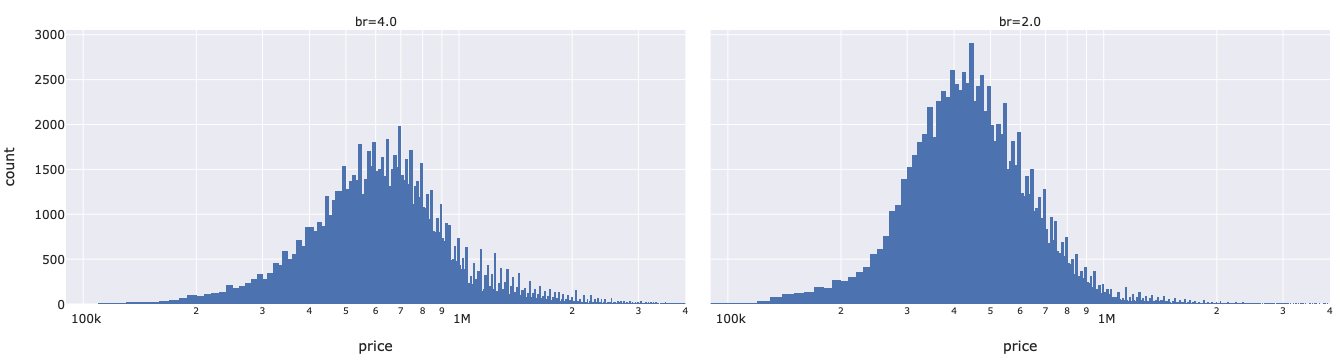

In [15]:
fig = px.histogram(sfh.query('br in [2, 4]'),
                   x='price', log_x=True, facet_col='br', width=700, height=250)
margin(fig, t=30)

We can compare quantiles with a quantile-quantile plot, called q-q plot for short. To make this plot, we first compute percentiles (also called quantiles) for both distributions. Then, we plot the matching percentiles on a scatter plot. We usually also show the reference line (y = x).

In [16]:
br2 = sfh.query('br == 2')
br4 = sfh.query('br == 4')
percs = np.arange(1, 100, 1)
perc2 = np.percentile(br2['price'], percs, interpolation='lower')
perc4 = np.percentile(br4['price'], percs, interpolation='lower')
perc_sfh = pd.DataFrame({'percentile': percs, 'br2': perc2, 'br4': perc4})
perc_sfh

percentile        br2        br4
0            1   150000.0   205000.0
1            2   182000.0   250000.0
2            3   203000.0   275000.0
..         ...        ...        ...
96          97  1035000.0  1750000.0
97          98  1200000.0  1950000.0
98          99  1437500.0  2337000.0

[99 rows x 3 columns]

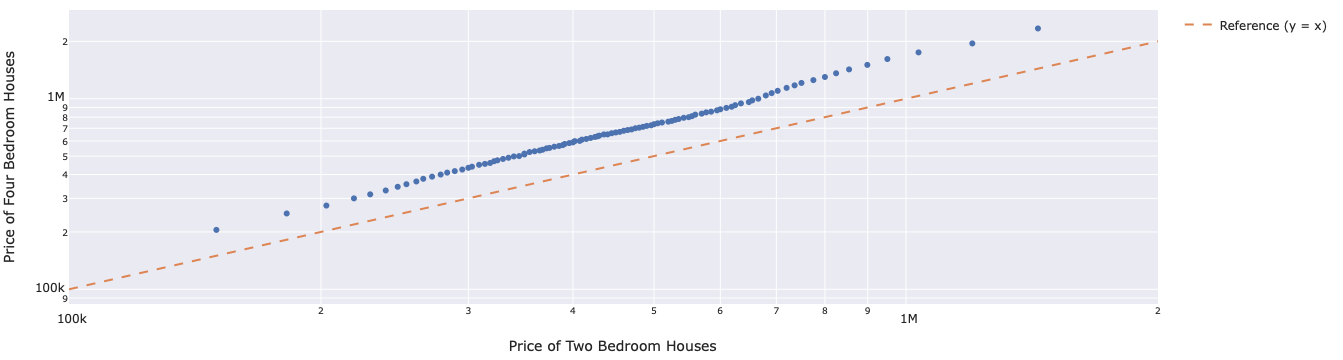

In [17]:
fig = px.scatter(perc_sfh, x='br2', y='br4', log_x=True, log_y=True, width=500, height=350,
                 labels={'br2': 'Price of Two Bedroom Houses',
                         'br4': 'Price of Four Bedroom Houses'})

fig.add_trace(
    go.Scatter(x=[1e5, 2e6], y=[1e5, 2e6], 
               mode='lines', line=dict(dash='dash'),
               name='Reference (y = x)')
)
fig

When the quantile points fall along a line, the variables have similarly shaped distributions. Lines parallel to the reference indicate a difference in center; lines with slopes other than 1 indicate a difference in spread, and curvature indicates a difference in shape. From the q-q plot above, we see that the distribution of price for four-bedroom houses is similar in shape to the two-bedroom distribution, except for a shift of about  in price and a slightly longer right tail (indicated by the upward bend for large values). Reading a q-q plot takes practice. Once you get the hang of it though, it can be a handy way to compare distributions. Notice that the housing data have over 100,000 observations, and the q-q plot has reduced the data to 99 percentiles. However, we don't always want to use smoothers. This is the topic of the next section.

When Not to Smooth
Smoothing and aggregating can help us see important features and relationships, but when we have only a handful of observations, smoothing techniques can give misleading representations of the data. With just a few observations, we prefer rug plots over histograms, box plots, and density curves, and we use scatter plots rather than smooth curves and density contours. This may seem obvious, but when we have a large amount of data, they can quickly dwindle when we split the data up into groups for comparisons. This phenomeon is an example of the "curse of dimensionality".

One of the most common misuses of smoothing happens with box plots. As an example, below is a collection of seven box plots of longevity, one for each dog-breed group. Some of these boxplots have as few as two or three observations.